# Assignment 2 Part 2: Let's Recover some Volumes!

After you finished the differentiable texture sampling notebook, you should have a better understanding of how automatic differentiation works in Slang. In this notebook, we'll extend the `DiffTexture2D` to `DiffTexture3D` to recover a 3D volume texture from a set of 2D rendered images.

In [1]:
import pathlib
import time
import slangpy as spy
from pyglm import glm
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from cs248a_renderer import setup_device, RendererModules
from cs248a_renderer.model.cameras import PerspectiveCamera
from cs248a_renderer.renderer.core_renderer import Renderer
from cs248a_renderer.model.volumes import DenseVolume
from cs248a_renderer.model.transforms import Transform3D
from cs248a_renderer.model.dataset import SpatialImageDataset

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Device setup
device = setup_device([])
renderer_modules = RendererModules(device)

In [3]:
# We setup the output image similar to part 1
OUTPUT_IMG_SIZE = (800, 800)
output_image = device.create_texture(
    type=spy.TextureType.texture_2d,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.unordered_access,
    width=OUTPUT_IMG_SIZE[0],
    height=OUTPUT_IMG_SIZE[1],
)
# Setup the renderer
renderer = Renderer(
    device=device,
    render_texture=output_image,
    render_modules=renderer_modules
)
renderer.sqrt_spp = 1
renderer._ambientColor = glm.vec4(0.0, 0.0, 0.0, 0.0)
# Create camera
camera = PerspectiveCamera()

## Acquire the Dataset

Download and unzip the `dataset.zip` from the assignment 2 resources folder: https://drive.google.com/drive/folders/1biYrBrNYx1sBlkcuyx3RARH9g9PaVHgL?usp=share_link and save it in the `resources` directory.

Let's start by loading the lego dataset. There're 100 images of size 800x800 rendered from different camera views around a lego model.

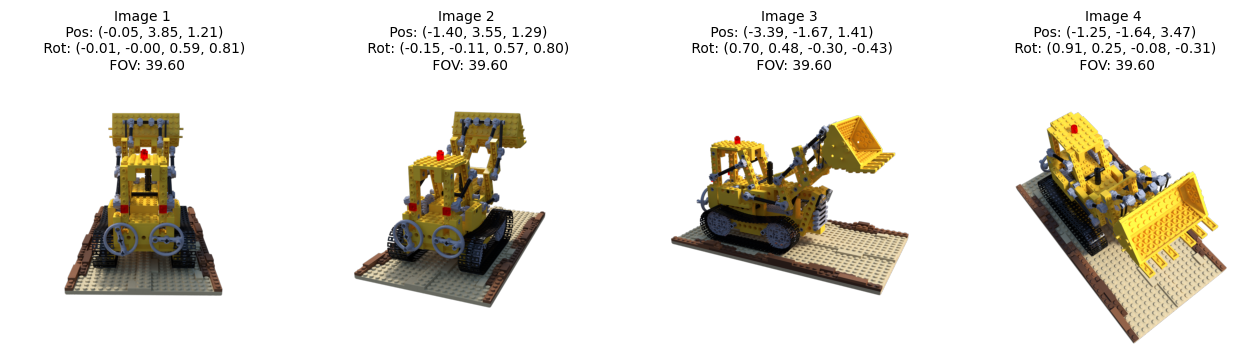

In [4]:
# Load the dataset
dataset = SpatialImageDataset(
    data_dir="../../../resources/dataset/lego"
)

# Visualize the first four images in the dataset.
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    img_gt, position, rotation, fov = dataset[i]
    axs[i].imshow(img_gt)
    axs[i].axis("off")
    pos = position.numpy()
    pos_str = f"({pos[0]:.2f}, {pos[1]:.2f}, {pos[2]:.2f})"
    rot_str = f"({rotation.numpy()[0]:.2f}, {rotation.numpy()[1]:.2f}, {rotation.numpy()[2]:.2f}, {rotation.numpy()[3]:.2f})"
    title = f"Image {i+1} \n Pos: {pos_str} \n Rot: {rot_str} \n FOV: {fov:.2f}"
    axs[i].set_title(title, fontsize=10)
plt.show()

Let's pick one training data `dataset[2]` to walk through the differentiable rendering pipeline.

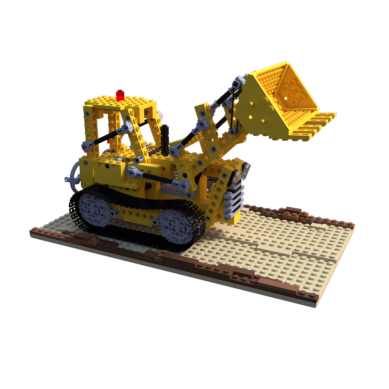

In [5]:
img_gt, position, rotation, fov = dataset[2]
plt.imshow(img_gt)
plt.axis("off")
plt.show()

## Initialize the Volume

Now, let's initialize a 3D volume texture with uniform random values from [0, 0.5]. The volume texture will be of size 128x128x128 with rgba channels representing the radiance and density values.

In [6]:
# Create a random volume
volume_size = (128, 128, 128)
volume_data = np.random.rand(volume_size[0], volume_size[1], volume_size[2], 4) * 0.5
dense_volume = DenseVolume(
    name="volume",
    transform=Transform3D(
        position=glm.vec3(0.0, 0.0, 0.0),
        rotation=glm.quat(1.0, 0.0, 0.0, 0.0),
        scale=glm.vec3(1.0, 1.0, 1.0),
    ),
    data=volume_data.astype(np.float32),
    properties={
        "pivot": (0.5, 0.5, 0.5),
        "voxel_size": 0.0175, # The size of each voxel in world units
    }
)

Let's render the volume from the same camera view as the ground truth image. If you implement the volume renderer from part 1 correctly, you should be able to see the following rendered image:

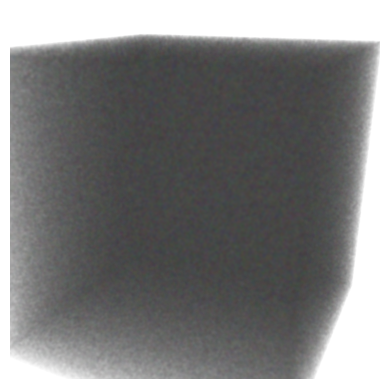

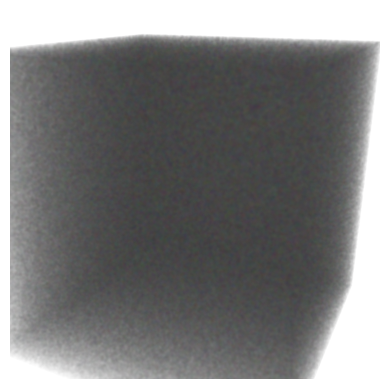

In [7]:
# Set camera parameters from the dataset
camera.transform.position = glm.vec3(*position)
camera.transform.rotation = glm.quat(*rotation)
camera.fov = fov
# Render the volume
renderer.load_volume(volume=dense_volume)
renderer.render(camera.view_matrix(), camera.fov)
# Store the render result in a tensor
img_res = torch.tensor(np.flipud(output_image.to_numpy()).copy(), requires_grad=True)
plt.imshow(img_res.detach().numpy())
plt.axis("off")
plt.show()

Similar to the differentiable texture sampling notebook, we can now compute the loss between the rendered image and the ground truth image, and backpropagate the gradients to update the volume texture.

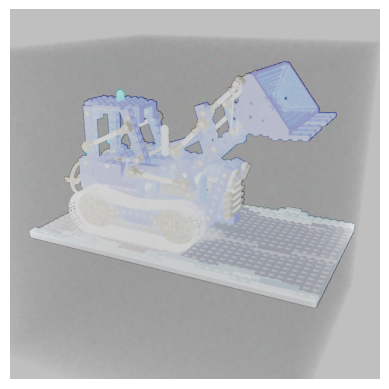

In [8]:
# Compute the loss
loss_fn = nn.MSELoss()
loss = loss_fn(img_res, img_gt)
# Calculate the gradient of the rendered image w.r.t. the loss
loss.backward()
grad_res = img_res.grad
# Display the normalized gradient
grad_res_vis = (grad_res - grad_res.min()) / (grad_res.max() - grad_res.min())
plt.imshow(grad_res_vis.detach().numpy())
plt.axis("off")
plt.show()

## Differentiable Volume Rendering Pipeline

Now, we've get to the most important part of this notebook: implementing the differentiable volume rendering pipeline.

In the differentiable texture sampling notebook, we implemented differentiable bilinear sampler in Slang. Here, we're replacing the bilinear sampler with a much more complex volume renderer.

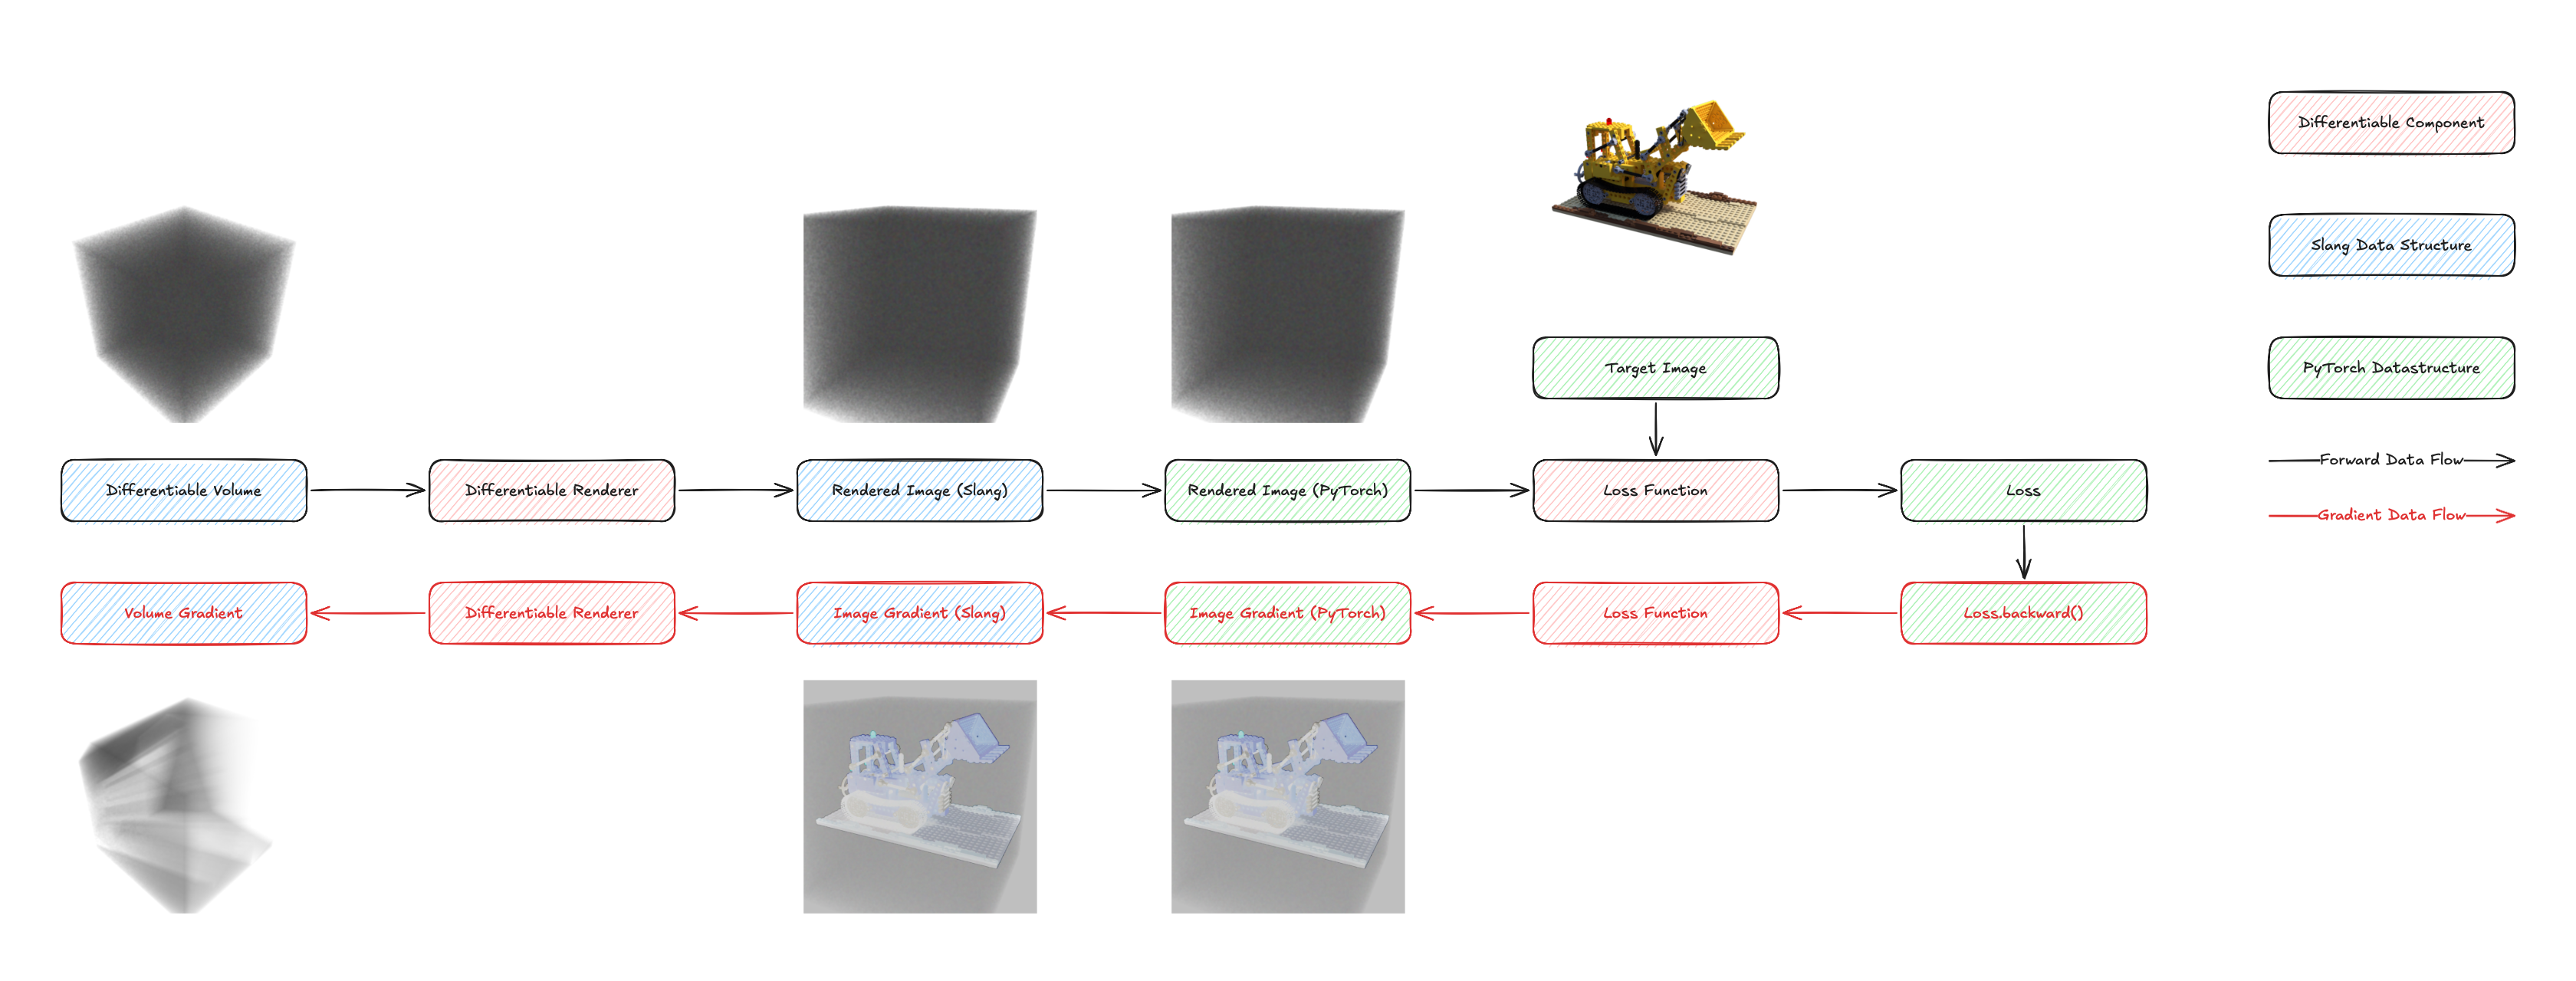

In part 1, you've implemented the `accumulateColor` function in `src/cs248a_renderer/slang_shaders/renderer/volume_renderer.slang` and used in the forward rendering function `volumeSample`.

Now, you'll use the `bwd_diff(accumulateColor)` in the `volumeSampleBwd` function to implement the backward pass of the volume renderer.

This function will be called by the `renderVolumeBwd` in `src/cs248a_renderer/slang_shaders/renderer.slang` for each pixel. And the `outGrad` parameter contains the gradient of the loss w.r.t. the rendered pixel (this is called the upstream gradient) color you've just computed in the previous cell.

> If you see a lot of compiler warnings about unused variables, you can safely ignore them. This is a small issue with the Slang compiler when generating code for atomic operations.

In [9]:
renderer.render_volume_backward(
    view_mat=camera.view_matrix(),
    fov=camera.fov,
    out_grad=torch.flipud(grad_res)
)
d_volume = renderer.get_d_volume()
d_volume = d_volume.reshape(volume_data.shape)
d_volume.shape

(128, 128, 128, 4)

Let's visualize the gradient of the volume by rendering an animation of it from different views. Run the following cell and play the saved video `volume_gradient_animation.mp4`.

Can you reason about why the gradient looks like this?

In [10]:
# Add an animation moving the camera around the volume to better visualize the recovered volume
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Load the volume gradient for visualization
d_volume_vis = d_volume / (d_volume.max() - d_volume.min())
grad_volume = DenseVolume(
    name="grad_volume",
    transform=Transform3D(
        position=glm.vec3(0.0, 0.0, 0.0),
        rotation=glm.quat(1.0, 0.0, 0.0, 0.0),
        scale=glm.vec3(1.0, 1.0, 1.0),
    ),
    data=d_volume_vis.astype(np.float32),
    properties={
        "pivot": (0.5, 0.5, 0.5),
        "voxel_size": 0.0175, # The size of each voxel in world units
    }
)
renderer.load_volume(volume=grad_volume)

# Get the current camera position and distance from origin
current_pos = np.array([position[0], position[1], position[2]]) * 1.5
distance = np.linalg.norm(current_pos)
current_rotation = np.array([rotation[0], rotation[1], rotation[2], rotation[3]])

# Calculate forward and up directions from the camera rotation
# Forward direction (negative Z in camera space)
forward = glm.normalize(glm.quat(*current_rotation) * glm.vec3(0, 0, -1))
# Up direction (positive Y in camera space)
up = glm.normalize(glm.quat(*current_rotation) * glm.vec3(0, 1, 0))
print(f"Forward direction: {forward}")
print(f"Up direction: {up}")
print(f"Camera distance from origin: {distance}")

# Render frames at different camera angles
num_frames = 60
rendered_frames = []
angles = np.linspace(0, 2 * np.pi, num_frames)

print("Rendering camera animation frames...")
for i, angle in enumerate(angles):
    if i % 10 == 0:
        print(f"Rendered {i}/{num_frames} frames")
    
    # Create a rotation matrix around the up axis
    up_axis = up
    # Rotate the current position around the up axis
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)
    
    # Create rotation matrix around the up axis
    up_arr = np.array([up_axis.x, up_axis.y, up_axis.z])
    
    # Rodrigues' rotation formula to rotate position around up axis
    pos_arr = np.array([current_pos[0], current_pos[1], current_pos[2]])
    rotated_pos = (pos_arr * cos_a + 
                   np.cross(up_arr, pos_arr) * sin_a + 
                   up_arr * np.dot(up_arr, pos_arr) * (1 - cos_a))
    
    # Set camera position
    camera.transform.position = glm.vec3(*rotated_pos)
    
    # Make camera look at origin
    cam_pos = glm.vec3(*rotated_pos)
    target = glm.vec3(0.0, 0.0, 0.0)
    cam_up = up
    # Create a look-at rotation
    forward_dir = glm.normalize(target - cam_pos)

    # Create rotation from basis vectors
    camera.transform.rotation = glm.quatLookAt(forward_dir, cam_up)
    camera.fov = fov
    
    # Render the scene
    renderer.render(camera.view_matrix(), camera.fov)
    rendered_frames.append(np.flipud(output_image.to_numpy().copy()))

print(f"Rendered {num_frames}/{num_frames} frames")

# Create animation
fig, ax = plt.subplots(figsize=(8, 8))

def animate_camera(frame):
    ax.clear()
    ax.imshow(rendered_frames[frame])
    ax.set_title(f'Camera Rotation Frame {frame+1}/{num_frames}')
    ax.axis('off')
    return ax,

anim = FuncAnimation(fig, animate_camera, frames=num_frames, interval=50, blit=False)
plt.close()

# Save the animation
anim.save("volume_recovery_animation.gif", writer="pillow", fps=30)

Forward direction: vec3(     0.839838,     0.414948,    -0.349987 )
Up direction: vec3(     0.313777,     0.155031,     0.936755 )
Camera distance from origin: 6.046693325042725
Rendering camera animation frames...
Rendered 0/60 frames
Rendered 10/60 frames
Rendered 20/60 frames
Rendered 30/60 frames
Rendered 40/60 frames
Rendered 50/60 frames


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5572088..0.6633282].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5572088..0.6633282].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6284491..0.67500436].


Rendered 60/60 frames


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5436555..0.67785674].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5009581..0.6912585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4140575..0.71949077].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30317712..0.7554661].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22096467..0.80364376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30168116..0.8574319].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

## Putting It All Together

Finally, let's implement the optimization loop to recover the volume texture from the dataset of images. Unlike the manual gradient optimization we did in the texture sampling notebook, here we'll leverage PyTorch's Adam optimizer to update the volume texture. This is a more neumerical stable and efficient optimization algorithm compared to vanilla SGD.

A few tips on connecting the Slang gradients with PyTorch optimizer:

- We've seen in the previous notebook and this notebook how to get the gradient out of a PyTorch tensor using `tensor.grad` after calling `loss.backward()`.
- Similarly, you can set the gradient of a PyTorch tensor by setting the `tensor.grad` field to a PyTorch tensor of the same shape.
- **Important**: Make sure to set the gradient inside a `with torch.no_grad():` block to avoid PyTorch tracking the assignment operation in the computation graph.

The following cell can take a while to run (around 5 minutes on my M3 Pro MacBook). We're also using tensorboard to log the training loss so you can monitor the training process to make sure everything is working correctly.

In your root directory of your virtual environment, run the following command to start tensorboard:

```bash
tensorboard --logdir resources/runs
```

Then open the provided URL in your browser to see the training loss curve. If you implemented everything correctly, you should see the training loss decreasing over time. This also makes it easier to tune the learning rate and other hyperparameters.

In [15]:
# DataLoader and checkpoint path
dataset = SpatialImageDataset(
    data_dir="../../../resources/dataset/hotdog"
)
recovered_path = pathlib.Path("../../../resources/hotdog_volume.npy")
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Create camera
camera = PerspectiveCamera()

# Init the volume data
volume_tensor = torch.empty((128, 128, 128, 4), dtype=torch.float32, requires_grad=True)
torch.nn.init.uniform_(volume_tensor, a=0.0, b=0.1)

# Optimizer setup (you are free to tune the learning rate and scheduler as you see fit)
optim = torch.optim.Adam([volume_tensor], lr=5e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.99)

# Store snapshots for animation
volume_snapshots = []
loss_values = []
snapshot_interval = 1  # Save every batch
writer = SummaryWriter(log_dir=f"../../../resources/runs/volume_recovery{time.time()}")
batch_count = 0
loss_fn = nn.MSELoss()

# Number of epochs to train (you're free to increase this if you want to produce better results)
num_epochs = 4
# Iterate through all data files
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    for i, (img_arr, position, rotation, fov) in tqdm(enumerate(data_loader), total=len(data_loader), desc="Batches"):
        batch_loss = 0.0

        # TODO: Student implementation starts here.

        # Load current volume once per batch (creates fresh zero gradient buffer)
        dense_volume.data = volume_tensor.detach().numpy()
        renderer.load_volume(volume=dense_volume)

        # Process each image in the batch
        for j in range(img_arr.shape[0]):
            # Set camera for this image
            camera.transform.position = glm.vec3(*position[j])
            camera.transform.rotation = glm.quat(*rotation[j])
            camera.fov = fov[j].item()

            # Forward render
            renderer.render(camera.view_matrix(), camera.fov)
            img_res = torch.tensor(np.flipud(output_image.to_numpy()).copy(), requires_grad=True)

            # Compute loss and image gradient
            loss = loss_fn(img_res, img_arr[j])
            loss.backward()
            batch_loss += loss.item()

            # Backward render (accumulates gradients in the volume gradient buffer)
            renderer.render_volume_backward(
                view_mat=camera.view_matrix(),
                fov=camera.fov,
                out_grad=torch.flipud(img_res.grad)
            )

        # Get accumulated volume gradients, feed to Adam optimizer
        d_volume = renderer.get_d_volume().reshape(volume_tensor.shape)
        with torch.no_grad():
            volume_tensor.grad = torch.tensor(d_volume, dtype=torch.float32)
        optim.step()
        optim.zero_grad()

        # TODO: Student implementation ends here.
        
        # Save snapshot every N batches
        if batch_count % snapshot_interval == 0:
            volume_snapshots.append(volume_tensor.detach().clone())
            loss_values.append(batch_loss / img_arr.shape[0])
        
        # Save to TensorBoard
        batch_count += 1
        writer.add_scalar("Loss/train", batch_loss / img_arr.shape[0], (epoch * len(data_loader) + i)* data_loader.batch_size)

    # Step the scheduler every epoch
    scheduler.step()
    # Save checkpoint
    np.save(recovered_path, volume_tensor.detach().numpy())

Epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

## Visualizing the Recovered Volume

Finally, let's visualize the optimization process by creating an animation of the learned texture and rendered image over epochs. Run the following cell and play the saved video `volume_recovery_sgd_animation.mp4`.

You can also visualize the recovered volume by loading the saved `resources/recovered_volume.npy` in the interactive renderer.

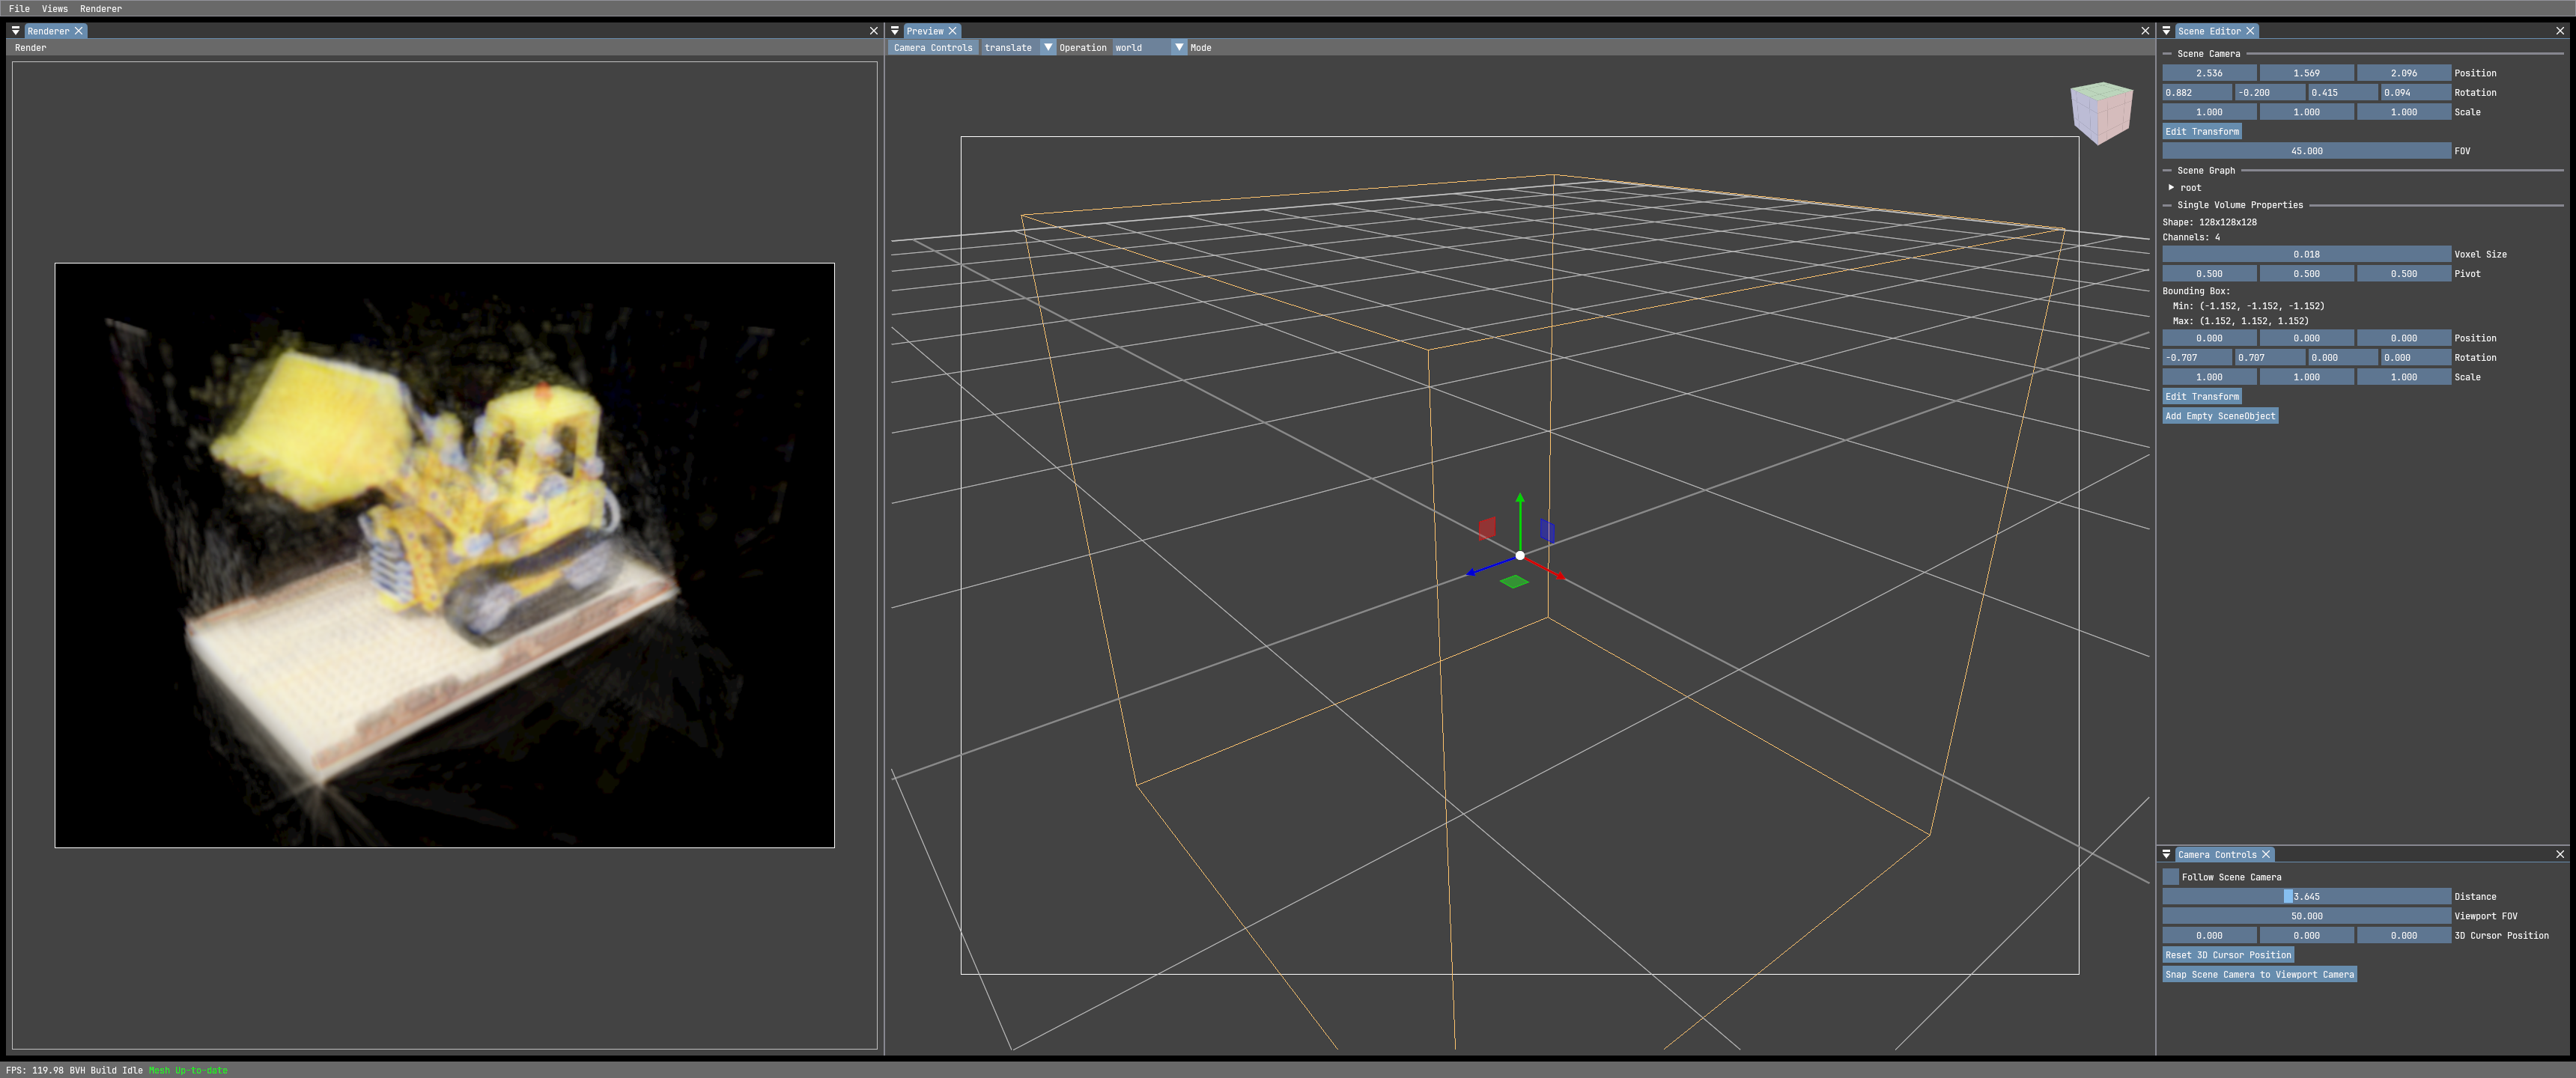

In [16]:
# Create animation showing volume recovery progress
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

print("Rendering animation frames...")
rendered_frames_front = []
rendered_frames_dataset = []

img, position, rotation, fov = dataset[0]

for i, volume_snapshot in enumerate(volume_snapshots):
    if i % 5 == 0:
        print(f"Rendered {i}/{len(volume_snapshots)} frames")
    
    # Create dense volume from snapshot
    dense_vol = DenseVolume(
        name="volume",
        transform=Transform3D(
            position=glm.vec3(0.0, 0.0, 0.0),
            rotation=glm.quat(1.0, 0.0, 0.0, 0.0),
            scale=glm.vec3(1.0, 1.0, 1.0),
        ),
        data=volume_snapshot.numpy(),
        properties={
            "pivot": (0.5, 0.5, 0.5),
            "voxel_size": 0.0175,
        }
    )
    renderer.load_volume(volume=dense_vol)
    
    # Render rotated view from
    camera.transform.position = glm.vec3(-3.0, 3.0, 3.0)
    # Rotate along the y-axis
    camera.transform.position = glm.angleAxis(glm.radians(i * 6), glm.vec3(0.0, 0.0, 1.0)) * camera.transform.position
    camera.transform.rotation = glm.quatLookAt(
        glm.normalize(-camera.transform.position),
        glm.vec3(0.0, 0.0, 1.0)
    )
    renderer.render(camera.view_matrix(), camera.fov)
    rendered_frames_front.append(np.flipud(output_image.to_numpy().copy()))
    
    # Render from dataset[2] camera
    camera.transform.position = glm.vec3(*position)
    camera.transform.rotation = glm.quat(*rotation)
    camera.fov = fov
    renderer.render(camera.view_matrix(), camera.fov)
    rendered_frames_dataset.append(np.flipud(output_image.to_numpy().copy()))

print(f"Rendered {len(volume_snapshots)}/{len(volume_snapshots)} frames")

# Create animation
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

def animate_recovery(frame):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    
    # Show volume
    ax1.imshow(rendered_frames_front[frame])
    ax1.set_title(f"Volume - Batch {frame * snapshot_interval}")
    ax1.axis("off")
    
    # Show rendered image from dataset camera
    ax2.imshow(rendered_frames_dataset[frame])
    ax2.set_title(f"View from one Dataset Camera - Batch {frame * snapshot_interval}")
    ax2.axis("off")
    
    # Show loss curve
    if frame > 0:
        ax3.plot(range(len(loss_values[:frame+1])), loss_values[:frame+1])
    ax3.set_xlim(0, len(loss_values))
    ax3.set_ylim(min(loss_values) * 0.9, max(loss_values) * 1.1)
    ax3.set_xlabel("Batch")
    ax3.set_ylabel("Loss")
    ax3.set_title("Loss Convergence")
    ax3.grid(True, alpha=0.3)
    ax3.set_box_aspect(1)
    
    return ax1, ax2, ax3

anim = FuncAnimation(fig, animate_recovery, frames=len(rendered_frames_front), interval=50, blit=False)
plt.tight_layout()
plt.close()

# Save the animation
anim.save("volume_recovery_sgd_animation_hotdog.gif", writer="pillow", fps=30)

Rendering animation frames...
Rendered 0/100 frames
Rendered 5/100 frames
Rendered 10/100 frames
Rendered 15/100 frames
Rendered 20/100 frames
Rendered 25/100 frames
Rendered 30/100 frames
Rendered 35/100 frames
Rendered 40/100 frames
Rendered 45/100 frames
Rendered 50/100 frames
Rendered 55/100 frames
Rendered 60/100 frames
Rendered 65/100 frames
Rendered 70/100 frames
Rendered 75/100 frames
Rendered 80/100 frames
Rendered 85/100 frames
Rendered 90/100 frames
Rendered 95/100 frames


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.040391684..0.7258345].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04597211..0.71997404].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.040391684..0.7258345].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04597211..0.71997404].


Rendered 100/100 frames


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42657137..0.78605044].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.60202193..0.78303903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.734892..0.85138416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96655047..0.8313289].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84317636..0.88279957].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9881102..0.84621745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-

## Train Your Own Volumes

In the dataset we provided, there are eight different scenes you can recover:

<video controls src="http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/website_renders/synth_grid_3.mp4"></video>

Please use recover two other scenes of your choice and submit all the recovered volumes in `.npy` file (`lego` and two other scenes) along with this notebook.

Think about which scenes are easier or harder to recover and why.